# __Brough Lecture Notes: GARCH Models - Monte Carlo & Bootstrap__

<br>

Finance 5330: Financial Econometrics <br>
Tyler J. Brough <br>
Last Updated: March 28, 2019 <br>
<br>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import seaborn
from numpy import size, log, exp, pi, sum, diff, array, zeros, diag, mat, asarray, sqrt, copy
from numpy.linalg import inv

## Simulating GARCH Models

We can use GARCH models for Monte Carlo simulation (taking parameters of the model as given). These notes are in part based on the book [Practical Financial Econometrics](https://amzn.to/2WyuJGj) by Carol Alexander. 

<br>

Let's start by simulating the return process and conditional volatilites. The GARCH returns/volatilities simulation algorithm is as follows: 

1. Fix an initial value for $\hat{\sigma}_{1}$ and set $t = 1$

2. Take a random draw $z_{t}$ from a standard normal iid process. 

3. Form $\epsilon_{t} = \hat{\sigma}_{t} z_{t}$ given the values of $z_{t}$ and $\hat{\sigma}_{t}$

4. Find $\hat{\sigma}_{t+1}$ from $\hat{\sigma}_{t}$ and $\epsilon_{t}$ using the estimated GARCH model (i.e. given $\hat{\theta} = \{\hat{\omega}, \hat{\alpha}, \hat{\beta}\}$)

<br>

The time series $\{\epsilon_{t}, \epsilon_{2}, \ldots, \epsilon_{T}\}$ is a simulated time series with mean zero that exhibits volatility clustering. 

<br>

We can implement this in Python as follows:

<br>

In [7]:
## Set GARCH parameters (these might come from an estimated model)
w = 10.0**-6
a = 0.085
b = 0.905

In [8]:
def simulate_garch(parameters, numObs):
    
    ## extract the parameter values
    mu = parameters[0]
    w = parameters[1]
    a = parameters[2]
    b = parameters[3]
    
    ## initialize arrays for storage
    z = np.random.normal(size=(numObs + 1))
    q = zeros((numObs + 1))
    r = zeros((numObs + 1))
    
    ## fix initial values 
    q[0] = w / (1.0 - a - b)
    r[0] = mu + z[0] * sqrt(q[0])
    e = (r[0] - mu) 
    
    ## run the main simulation loop
    for t in range(1, numObs + 1):
        q[t] = w + a * (e * e) + b * q[t-1]
        r[t] = mu + z[t] * sqrt(q[t])
        e = (r[t] - mu) 
        
    ## return a tuple with both returns and conditional volatilities
    return (r, q)

In [9]:
## number of trading days per year
numObs = 252

## daily continuously compounded rate of return correpsonding to 15% annual
mu = log(1.15) / 252

## drift and GARCH(1,1) parameters in an array
params = array([mu, w, a, b])

## run the simulation
r, s = simulate_garch(params, numObs)

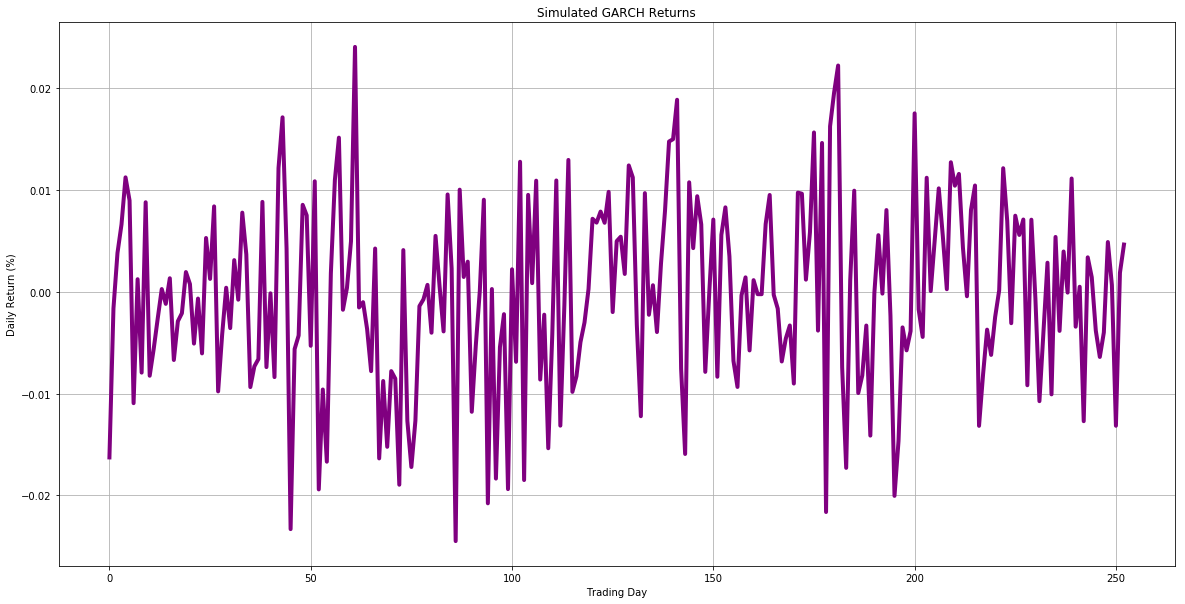

In [10]:
## plot the simulated returns path
fig, ax = plt.subplots()
#ax.plot_date(r, linestyle='--')
ax.grid(True)
plt.title("Simulated GARCH Returns")
plt.ylabel("Daily Return (%)")
plt.xlabel("Trading Day")
plt.plot(r, linewidth=4, color="purple")
plt.show()

In [11]:
## let's look at the first 10 observations
r[:10]

array([-0.01627597, -0.00163799,  0.00381906,  0.00662521,  0.01125134,
        0.00897889, -0.01094331,  0.00124103, -0.00793993,  0.00880479])

In [12]:
## let's look at the last 10 observations
r[-10:]

array([ 0.00339074,  0.00143083, -0.00380506, -0.00640026, -0.00399367,
        0.00489446,  0.00067027, -0.01316526,  0.00187587,  0.00464696])

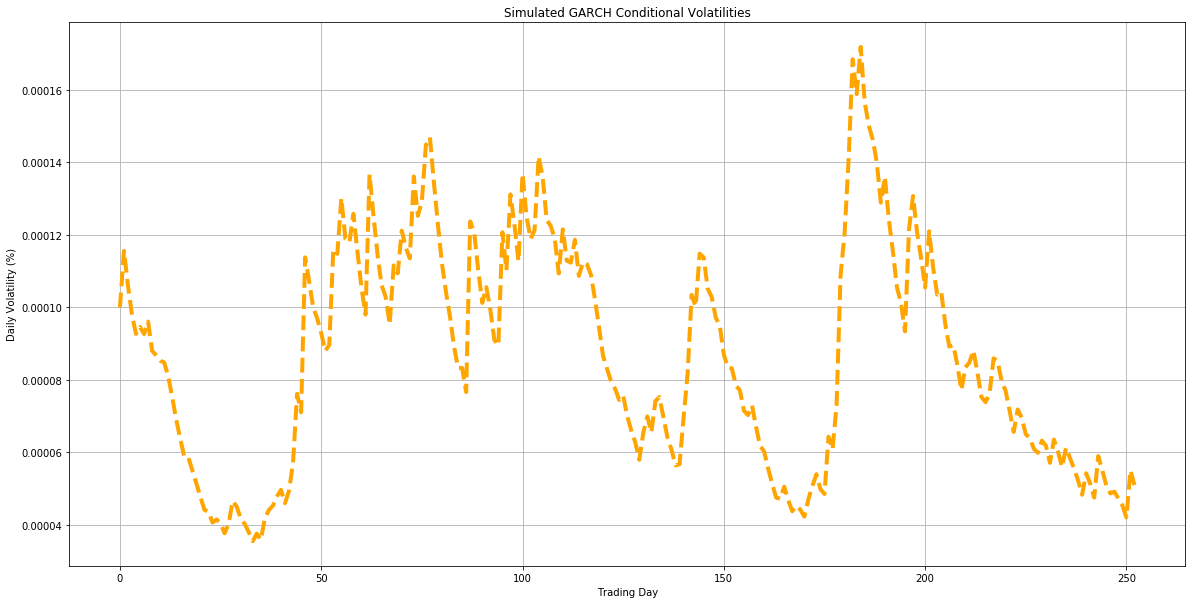

In [13]:
## plot the simulated conditional volatilities
fig, ax = plt.subplots()
#ax.plot_date(r, linestyle='--')
ax.grid(True)
plt.title("Simulated GARCH Conditional Volatilities")
plt.ylabel("Daily Volatility (%)")
plt.xlabel("Trading Day")
plt.plot(s, linestyle='--', linewidth=4, color="orange")
plt.show()

<br>

Given a time series of simulated returns, we can now use these to simulate asset prices if we wish.

<br>

We do this as follows for the log-price as follows. We express the simulated returns as $\hat{r}_{t} = \mu + z_{t} \cdot \hat{\sigma}_{t}$

$$
\ln{(S_{t})} = \ln{(S_{t-1})} + \mu + z_{t-1} \cdot \hat{\sigma}_{t-1}
$$

<br>

Or for dollar prices:

$$
S_{t} = S_{t-1} \exp{(\hat{r}_{t-1})}
$$

<br>

We do this in Python with the following:

<br>

In [14]:
## initialize the spot price array
spot = zeros(numObs)
spot[0] = 100.0


## run the main simulation loop
for t in range(1, numObs):
    spot[t] = spot[t-1] * exp(r[t-1])

In [15]:
## let's look at the first 10 prices
spot[:10]

array([100.        ,  98.38557723,  98.22455438,  98.60039731,
        99.25581456, 100.37888199, 101.28423152, 100.18188987,
       100.30629543,  99.51302415])

In [16]:
## let's look at the last 10 prices
spot[-10:]

array([94.89250475, 93.69367817, 94.01190808, 94.14651903, 93.788967  ,
       93.19060996, 92.8191797 , 93.27459292, 93.33713331, 92.11637947])

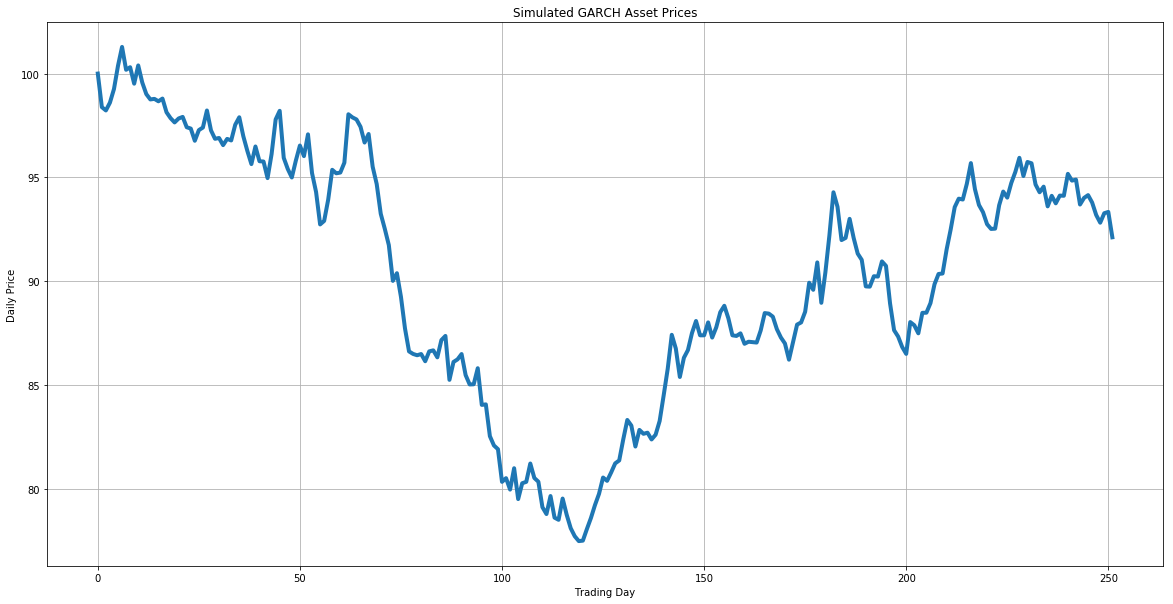

In [17]:
## plot the simulated price path
fig, ax = plt.subplots()
#ax.plot_date(r, linestyle='--')
ax.grid(True)
plt.title("Simulated GARCH Asset Prices")
plt.ylabel("Daily Price")
plt.xlabel("Trading Day")
plt.plot(spot, linestyle='-', linewidth=4)
plt.show()